# Writing a class to store tick data

Write a class named TickData that represents a single unit of
data received from a market data source with the following
Python code:

In [ ]:
class TickData(object):
	""" Stores a single unit of data """

	def __init__(self, timestamp='', symbol='',
				open_price=0, close_price=0, total_volume=0):
		self.symbol = symbol
		self.timestamp = timestamp
		self.open_price = open_price
		self.close_price = close_price
		self.total_volume = total_volume

# Writing a class to store market data

An instance of the MarketData class is used throughout the
system to store and retrieve prices referenced by various
components. Essentially, it is a container for storing the last
available tick data. Additional get helper functions are included
to provide easy reference to the required information:

In [ ]:
class MarketData(object):
	def __init__(self):
		self.recent_ticks = dict()  # indexed by symbol

	def add_tick_data(self, tick_data):
		self.recent_ticks[tick_data.symbol] = tick_data

	def get_open_price(self, symbol):
		return self.get_tick_data(symbol).open_price

	def get_close_price(self, symbol):
		return self.get_tick_data(symbol).close_price

	def get_tick_data(self, symbol):
		return self.recent_ticks.get(symbol, TickData())

	def get_timestamp(self, symbol):
		return self.recent_ticks[symbol].timestamp

# Writing a class to generate sources of market data

In [ ]:
!pip install quandl

Write a class called MarketDataSource to help us fetch historical
data from an external data provider. In this example, we will
be using Quandl as our data provider. The constructor of the
class is defined as follows:

In the constructor, the symbol parameter contains the value
recognized by our data provider to download our desired
dataset. An object of MarketData is instantiated for storing the
most recent market data available. The tick_event_handler
parameter stores the method handler as we iterate through
our data source. The start and end parameters refer to the
starting and ending dates of the dataset that we wish to keep
in the pandas DataFrame variable, df.
Add the fetch_historical_prices() method inside
the MarketDataSource method containing specific instructions for
downloading from our data provider and returning the desired
pandas DataFrame object, which holds our daily market prices,
as shown in the following code:

In [ ]:
class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        import quandl

        # Update your Quandl API key here...
        QUANDL_API_KEY = 'yz7qGzikAuQL9wn7rrX-'

        quandl.ApiConfig.api_key = QUANDL_API_KEY
        df = quandl.get(self.symbol, start_date=self.start, end_date=self.end)
        return df

    def run(self):
        if self.df is None:
            self.df = self.fetch_historical_prices()

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks)

        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)

# Writing the order class

The Order class in the following code represents a single order
sent by the strategy to the server. Each order contains a
timestamp, the symbol, quantity, and a flag indicating a buy or
sell order. In the following examples, we will be using market
orders only, and is_market_order is expected to be True. Other order
types, such as limit and stop orders, may be implemented if
desired. Once an order is filled, the order is further updated
with the filled price, time, and quantity. Write this class as
given in the following code:

In [ ]:
class Order(object):
	def __init__(self, timestamp, symbol, 
		qty, is_buy, is_market_order, 
		price=0
	):
		self.timestamp = timestamp
		self.symbol = symbol
		self.qty = qty
		self.price = price
		self.is_buy = is_buy
		self.is_market_order = is_market_order
		self.is_filled = False
		self.filled_price = 0
		self.filled_time = None
		self.filled_qty = 0

# Writing a class to keep track of positions

The Position class helps us keep track of our current market
position and account balance for a traded instrument, and is
written as follows:

The number of units bought, sold, and net are declared as buys,
sells, and net variables, respectively. The rpnl variable stores the
recently realized profits and losses for the symbol. Note that
the position_value variable starts with a value of zero. When
securities are bought, the value of the securities is debited
from this account. When securities are sold, the value of the
securities is credited into this account.
When an order is filled, an account's position changes. Write a
method named on_position_event() inside the Position class to
handle these position events:

In [ ]:
class Position(object):
	def __init__(self, symbol=''):
		self.symbol = symbol
		self.buys = self.sells = self.net = 0
		self.rpnl = 0
		self.position_value = 0

	def on_position_event(self, is_buy, qty, price):
		if is_buy:
			self.buys += qty
		else:
			self.sells += qty

		self.net = self.buys - self.sells
		changed_value = qty * price * (-1 if is_buy else 1)
		self.position_value += changed_value

		if self.net == 0:
			self.rpnl = self.position_value
			self.position_value = 0

	def calculate_unrealized_pnl(self, price):
		if self.net == 0:
			return 0

		market_value = self.net * price
		upnl = self.position_value + market_value
		return upnl

# Writing an abstract strategy class

The Strategy class given in the following code is the base class
for all other strategy implementations, and is written as:

In [ ]:
from abc import abstractmethod

class Strategy:
	def __init__(self, send_order_event_handler):
		self.send_order_event_handler = send_order_event_handler

	@abstractmethod
	def on_tick_event(self, market_data):
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def on_position_event(self, positions):
		raise NotImplementedError('Method is required!')

	def send_market_order(self, symbol, qty, is_buy, timestamp):
		if self.send_order_event_handler:
			order = Order(
				timestamp,
				symbol,
				qty,
				is_buy,
				is_market_order=True,
				price=0,
			)
			self.send_order_event_handler(order)

# Writing a mean-reverting strategy class

In this example, we are implementing a mean-reverting
trading strategy on the AAPL stock price. Write the
MeanRevertingStrategy child class that inherits the Strategy class from
the previous section:

In [ ]:
import pandas as pd

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-1.5, sell_threshold=1.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

# Binding our modules with a backtesting engine

After defining all of our core modular components, we are now
ready to implement the backtesting engine as the BacktestEngine
class with the following codes:

In [ ]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

# Running our backtesting engine

In [ ]:
engine = BacktestEngine(
    'WIKI/AAPL', 1,
    start='2015-01-01',
    end='2017-12-31'
)

In [ ]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5,
    sell_threshold=1.5
)

Backtest started...
Processing total_ticks: 753
2015-01-02 TICK WIKI/AAPL open: 111.39 close: 109.33
2015-01-05 TICK WIKI/AAPL open: 108.29 close: 106.25
2015-01-06 TICK WIKI/AAPL open: 106.54 close: 106.26
2015-01-07 TICK WIKI/AAPL open: 107.2 close: 107.75
2015-01-08 TICK WIKI/AAPL open: 109.23 close: 111.89
2015-01-09 TICK WIKI/AAPL open: 112.67 close: 112.01
2015-01-12 TICK WIKI/AAPL open: 112.6 close: 109.25
2015-01-13 TICK WIKI/AAPL open: 111.43 close: 110.22
2015-01-14 TICK WIKI/AAPL open: 109.04 close: 109.8
2015-01-15 TICK WIKI/AAPL open: 110.0 close: 106.82
2015-01-16 TICK WIKI/AAPL open: 107.03 close: 105.99
2015-01-20 TICK WIKI/AAPL open: 107.84 close: 108.72
2015-01-21 TICK WIKI/AAPL open: 108.95 close: 109.55
2015-01-22 TICK WIKI/AAPL open: 110.26 close: 112.4
2015-01-23 TICK WIKI/AAPL open: 112.3 close: 112.98
2015-01-26 TICK WIKI/AAPL open: 113.74 close: 113.1
2015-01-27 TICK WIKI/AAPL open: 112.42 close: 109.14
2015-01-28 TICK WIKI/AAPL open: 117.625 close: 115.31
2015

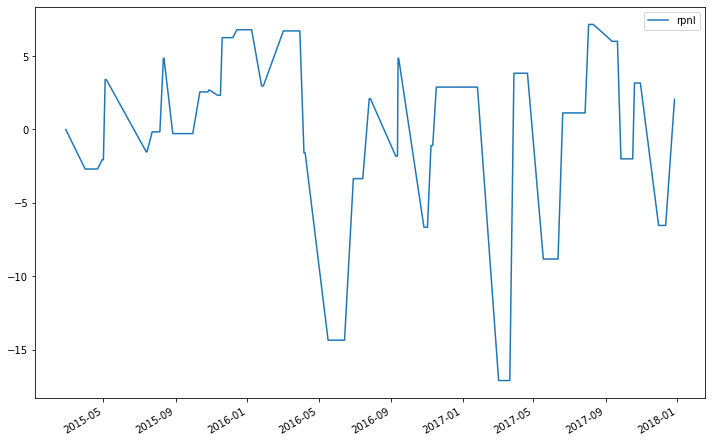

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

engine.df_rpnl.plot(figsize=(12, 8));

# Multiple runs of the backtest engine

In [ ]:
THRESHOLDS = [
    (-0.5, 0.5),
    (-1.5, 1.5),
    (-2.5, 2.0),
    (-1.5, 2.5),
]

Streaming output truncated to the last 5000 lines.
2017-07-25 POSITION value:151.800 upnl:-0.940 rpnl:-6.970
2017-07-26 TICK WIKI/AAPL open: 153.35 close: 153.46
2017-07-26 POSITION value:151.800 upnl:-1.660 rpnl:-6.970
2017-07-27 TICK WIKI/AAPL open: 153.75 close: 150.56
2017-07-27 BUY signal
2017-07-27 ORDER BUY WIKI/AAPL 1
2017-07-27 POSITION value:151.800 upnl:1.240 rpnl:-6.970
2017-07-28 TICK WIKI/AAPL open: 149.89 close: 149.5
2017-07-28 FILLED BUY 1 WIKI/AAPL at 149.89
2017-07-28 BUY signal
2017-07-28 ORDER BUY WIKI/AAPL 1
2017-07-28 POSITION value:0.000 upnl:0.000 rpnl:1.910
2017-07-31 TICK WIKI/AAPL open: 149.9 close: 148.85
2017-07-31 FILLED BUY 1 WIKI/AAPL at 149.9
2017-07-31 POSITION value:-149.900 upnl:-1.050 rpnl:1.910
2017-08-01 TICK WIKI/AAPL open: 149.1 close: 150.05
2017-08-01 SELL signal
2017-08-01 ORDER SELL WIKI/AAPL 1
2017-08-01 POSITION value:-149.900 upnl:0.150 rpnl:1.910
2017-08-02 TICK WIKI/AAPL open: 159.28 close: 157.14
2017-08-02 FILLED SELL 1 WIKI/AAPL at 

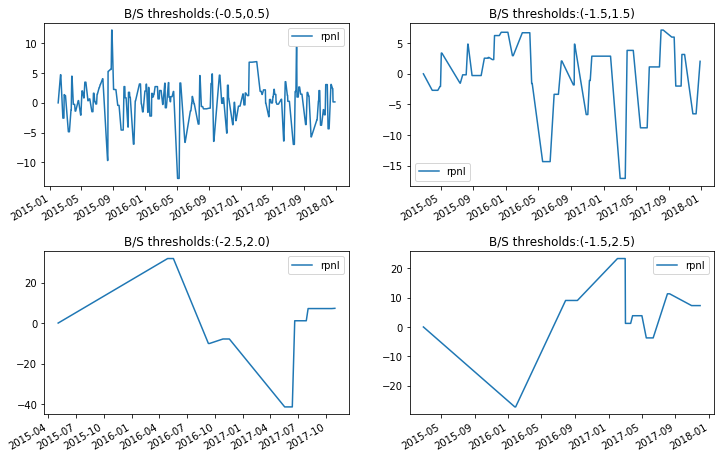

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(THRESHOLDS)//2, 
    ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
for i, (buy_threshold, sell_threshold) in enumerate(THRESHOLDS):
    engine.start(
        lookback_intervals=20,
        buy_threshold=buy_threshold,
        sell_threshold=sell_threshold
    )
    df_rpnls = engine.df_rpnl
    ax = axes[i // 2, i % 2]
    ax.set_title(
        'B/S thresholds:(%s,%s)' % 
        (buy_threshold, sell_threshold)
    )
    df_rpnls.plot(ax=ax)